# N-step Learning from Scratch

Mutli-step targets with suitable choices of $n$ often lead to faster learning (Sutton and Barto, 1998)

# Imports & Constants

In [1]:
import sys
import os

# Assuming the notebook is located inside `subfolder` and
# we want to import a module in `parent_folder`

# Get the absolute path to the 'subfolder'.
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Calculate the path to the 'parent_folder' by going one level up.
parent_dir = os.path.dirname(notebook_dir)

# Add the 'parent_folder' to sys.path if it is not already there.
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
import os
import math
import time

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from numpy import float64, ndarray
from IPython.display import clear_output
from collections import deque
from typing import Dict, List, Tuple, Deque

from agents import MlpDQNAgent
from buffers import ReplayBuffer
from networks import Network

# N-step Replay Buffer

In [3]:
class NStepReplayBuffer(ReplayBuffer):
    """
    Class representing a simple experience replay buffer for n-step learning.
    """

    def __init__(
        self,
        obs_shape: Tuple, 
        size: int, 
        batch_size: int = 32,
        n_step: int = 3,
        gamma: float = 0.99,
    ):
        super().__init__(obs_shape, size, batch_size)

        # The n-step buffer stores at most `n_step` number of transitions.
        self.n_step_buffer = deque(maxlen=n_step)
        self.n_step = n_step
        self.gamma = gamma

    def store(self, obs: np.ndarray, act: np.ndarray, rew: np.ndarray, next_obs: np.ndarray, done: bool):
        transition = (obs, act, rew, next_obs, done)
        self.n_step_buffer.append(transition)

        # If there aren't enough transitions for n-step learning yet.
        if len(self.n_step_buffer) < self.n_step:
            return ()
        
        # Prepare an n-step transition.
        rew, next_obs, done = self._prepare_n_step_info()
        obs, act = self.n_step_buffer[0][:2]

        # Store the transition.
        super().store(obs, act, rew, next_obs, done)

        return self.n_step_buffer[0]
    
    def sample_batch_from_idxs(self, indices: np.ndarray) -> Dict[str, np.ndarray]:
        return dict(
            obs=self.obs_buf[indices],
            next_obs=self.next_obs_buf[indices],
            acts=self.acts_buf[indices],
            rews=self.rews_buf[indices],
            done=self.done_buf[indices],
        )

    def _prepare_n_step_info(self) -> Tuple[np.float32, np.ndarray, bool]:
        """
        Returns the n_step reward, subsequent observation and whether or not
        the episode has completed.
        """
        rew, next_obs, done = self.n_step_buffer[-1][-3:]

        # Iterating backwards through the n-step buffer.
        for transition in reversed(list(self.n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:]

            rew = r + self.gamma * rew * (1 - d)
            next_obs, done = (n_o, d) if d else (next_obs, done)

        return rew, next_obs, done

# N-step Learning DQN Agent

In [4]:
class NStepDQNAgent(MlpDQNAgent):

    def __init__(
        self,        
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float = 1e-4,
        seed: int = 42,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
        # N-step Learning
        n_step: int = 3,
    ):
        super().__init__(
            env, 
            memory_size, 
            batch_size, 
            target_update, 
            epsilon_decay, 
            seed, 
            max_epsilon, 
            min_epsilon, 
            gamma
        )

        # Memory for 1-step learning.
        self.memory = NStepReplayBuffer(
            self.obs_shape, memory_size, batch_size, n_step=1, gamma=gamma
        )

        # Memory for N-step learning.
        self.use_n_step = n_step > 1
        if self.use_n_step:
            self.n_step = n_step
            self.memory_n = NStepReplayBuffer(
                self.obs_shape, memory_size, batch_size, n_step=n_step, gamma=gamma
            )

    def step(self, action: ndarray) -> Tuple[ndarray, float64, bool]:
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        
        if not self.is_test:
            self.transition += [reward, next_state, done]
            
            # N-step transition
            if self.use_n_step:
                one_step_transition = self.memory_n.store(*self.transition)
            # 1-step transition
            else:
                one_step_transition = self.transition

            # Add a single step transition
            if one_step_transition:
                self.memory.store(*one_step_transition)
    
        return next_state, reward, done
    
    def update_model(self) -> torch.Tensor:
        samples = self.memory.sample_batch()
        indices = samples["indices"]
        loss = self._compute_dqn_loss(samples, self.gamma)

        # N-step Learning loss. We combine 1-step and n-step loss so as to
        # prevent high variance.
        if self.use_n_step:
            samples = self.memory_n.sample_batch_from_idxs(indices)
            gamma = self.gamma ** self.n_step
            n_loss = self._compute_dqn_loss(samples, gamma)
            loss += n_loss

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        return loss.item()

# Train an agent

In [7]:
config = {
    'lanes_count': 3,
    'duration': 50,
}

In [8]:
env = gym.make("highway-fast-v0", render_mode="rgb_array")
env.unwrapped.configure(config)
obs, info = env.reset()

In [9]:
seed = 777
num_frames = 2_000_000
memory_size = 100_000
gamma = 0.85
batch_size = 64
target_update = 100
epsilon_decay = 1 / (num_frames // 10)

agent = NStepDQNAgent(
    env,
    memory_size,
    batch_size,
    target_update,
    epsilon_decay,
    seed,
    gamma=gamma,
)

cuda


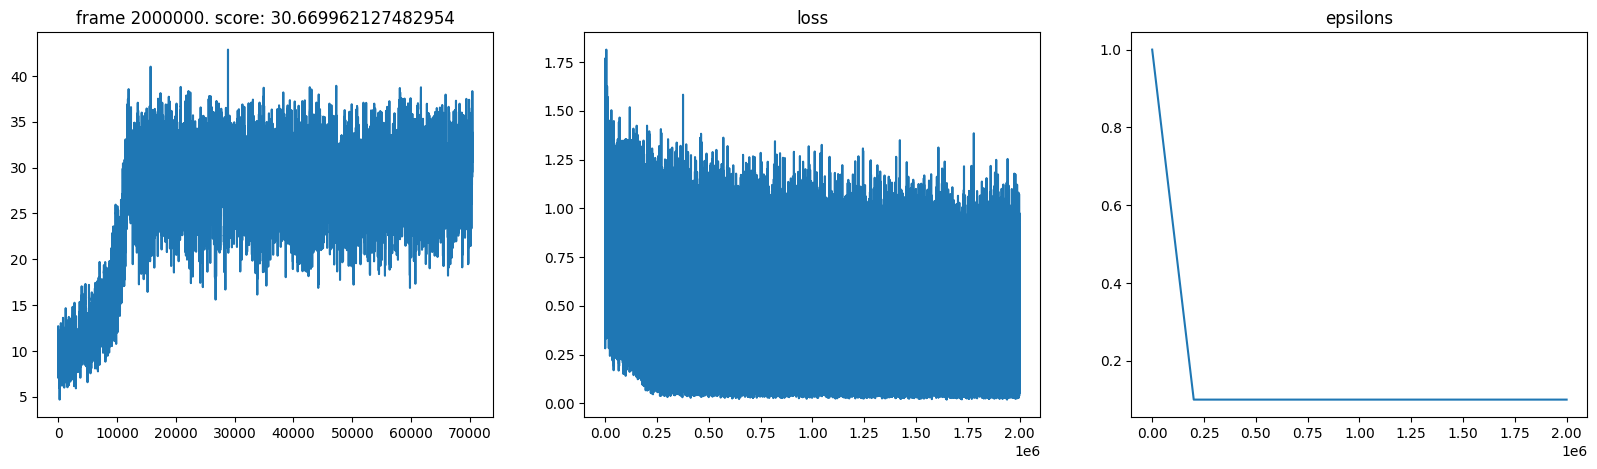

In [10]:
agent.train(num_frames)

# Test the agent

In [11]:
ep_lens, ep_rews = agent.test(1000, render=False, time_interval=0)

In [12]:
print("Mean Episode Length:", np.mean(ep_lens))
print("Mean Score Per Episode:", np.mean(ep_rews))

Mean Episode Length: 43.831
Mean Score Per Episode: 41.68956249108418
